# Latent Probability Model

If you are running this for the first time you may need to use the following commands before continuing:

In [5]:
!pip install pandas
!pip install spacy
!pip install spacytextblob
!python -m spacy download en_core_web_sm

!pip install newspaper3k

!pip install plotly

!pip install sklearn

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Spacy: Used for NLP and has the machine learning module
    
SpacyTextBlob: Used for the sentiment analysis
    
Pandas: Stores the data as a dataframe table
    
NewsPaper: Used for web scraping
    
Requests: Makes the connection to the URL

In [222]:
from newspaper import Article
from random import shuffle
import re
import matplotlib.pyplot as plt 
from collections import Counter

import numpy as np
import json
import requests
import glob

#gensim
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary  # Import the Dictionary class from Gensim

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim
import plotly.express as px
import matplotlib.colors as mcolors
import sklearn
from sklearn.manifold import TSNE

from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
import requests

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [223]:
%run SentimentAnalysis.ipynb
%run WebScraper.ipynb
%run PipelineHelpers.ipynb
%run TopicModeling.ipynb
%run DataVisualization.ipynb

IMPORTANT: Insert the .csv file you want to be read below.

In [224]:
csvFile = "urls_gabriel_generated.csv"
wordCountFilter = 150
social_starts_with = ["https://www.youtube.com", "https://youtu.be", "https://www.facebook.com", 
                     "https://twitter.com", "https://gettr.com/"]


IMPORTANT: If you want to try re-runing after making some code changes or want to 
run a new .csv file through, run the code block below.

In [225]:
# Loading our two pipelines
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# Using panda to load in our .csv file
df = pd.read_csv(csvFile) # File we are checking
urls = df["Address"].tolist() # Column name we are checking
all_text_gathered = []
all_articles = ''
scentence_list = []


# This is the pipeline. All code is called and ran through here.

0
word count  39
repeated phrases 1
https://www.bbc.com/news/world-us-canada-55805698


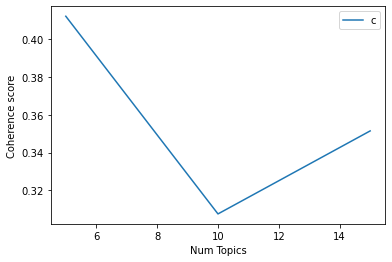

In [226]:
# Loops through our URLS and scraps the data
# Put all empty dictionaries here
sentimentDic = {}
    
for count, x in enumerate(urls):
    if(count % 10 == 0):
        print(str(count))

    url = x

    # Send the URL to get scraped
    page_text = scrapeData(x)
    # All articles will have a long string of all the text that has been scraped
    all_articles = all_articles + " " +  page_text
    
    # Puts the article into a list of all the sentences in the article
    sentenceList = sentenceLevel(page_text)

    # Runs sentiment analysis. Will pass in the page_text, the dic, and x (the url)
    sentimentDic = sentimentAnalysis(page_text, sentimentDic, url)
    

# For each analysis we run we need to then convert that dictionary with the following method
df = dictionaryToDataFrame(sentimentDic)

topisSentAnalysis = topic_sentence_sentiment_analysis(df, sentimentDic)

# Used if we want to convert it to a .csv 
#sentDic.to_csv("sentiment130.csv")


# Dropping failed webscraping rows

In [8]:
df = drop_failed_webscraping_rows(df)
df

,URL,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Text
0,https://www.foxnews.com/politics/hunter-bidens...,0.04,Neutral,0.24,"unpaid, legal, first, new, best, more, main","down, approximately, least, firm, limited, pre...","exclusive: the $250,000 wire hunter biden rece..."
1,https://www.foxnews.com/politics/doj-ordered-h...,0.06,Neutral Positive,0.35,"detailed, special, normal, light, first, exact...","artificially, other, foreign, subject, crimina...",the u.s. department of justice ordered fbi and...
2,https://www.foxnews.com/politics/hunter-biden-...,-0.04,Neutral Negative,0.37,"many, direct, legal, first, primarily, general...","guilty, jail, falsely, expected, other, failur...",hunter biden on tuesday filed a lawsuit agains...
3,https://apnews.com/article/hunter-biden-impeac...,0.02,Neutral Negative,0.37,"right, many, legal, promising, action, first, ...","thin, down, military, expected, skeptical, cri...",washington (ap) — house republicans launched a...
4,https://www.nation.com.pk/21-Jun-2023/hunter-b...,-0.04,Neutral Negative,0.44,"detailed, love, first, important, not, social","due, guilty, other, failure, least, criminal, ...","washigton-hunter biden, the son of president j..."
5,https://www.nation.com.pk/25-Jul-2021/white-ho...,0.10,Neutral Positive,0.41,"ethically, new, artistic, winning, ethical, ec...",half,washington - the white house assured saturday ...
6,https://www.nation.com.pk/24-Dec-2019/hunter-b...,-0.11,Negative,0.40,"more, new, nearly","guilty, allegedly, criminal, subject, behind, ...",hunter biden is the subject of multiple crimin...
7,https://www.cnn.com/2023/09/27/politics/house-...,-0.01,Neutral Negative,0.35,"unpaid, directly, legal, apparent, significant...","closed, frustrated, other, single, foreign, cr...",washington cnn —\ndocuments released wednesday...
9,https://abcnews.go.com/Politics/comer-issue-su...,0.01,Neutral Negative,0.40,"directly, first, new, top, far, more","other, extreme, mean, late, missing, previously",house oversight committee chairman james comer...


# Create Topic Model w/ Highest Coherence

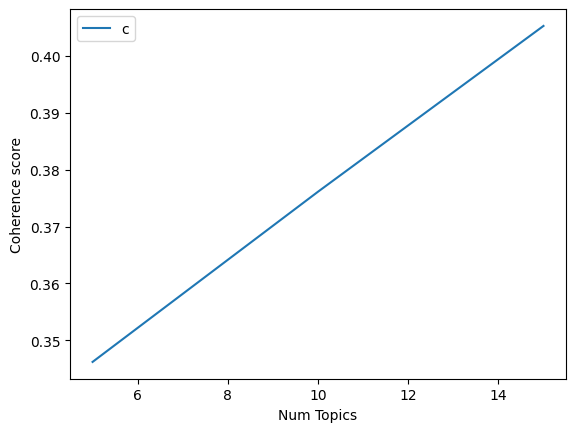

In [9]:
#This will generate multiple topic models with various topic count, then return the model with highest coherence
#it will also display a quick visual of coherence values, to understand what topic count is best and why it was chosen
LDA_model, corpus = create_lda_model(df, 20, 5, 5)
LDA_model

In [11]:
#here we create a list of topic words and their associated weights
LDA_model_topics = LDA_model.print_topics() #LDA_model[corpus]

LDA_model_topics.sort()
print(len(LDA_model_topics))
LDA_model_topics


15


[(0,
  '0.002*"say" + 0.001*"hearing" + 0.001*"republican" + 0.001*"document" + 0.001*"president" + 0.001*"impeachment" + 0.001*"business" + 0.001*"family" + 0.001*"political" + 0.001*"release"'),
 (1,
  '0.002*"laptop" + 0.002*"email" + 0.002*"video" + 0.002*"obtain" + 0.001*"ten" + 0.001*"drive" + 0.001*"disseminate" + 0.001*"hire" + 0.001*"information" + 0.001*"repair"'),
 (2,
  '0.001*"say" + 0.001*"republican" + 0.001*"address" + 0.001*"hearing" + 0.001*"impeachment" + 0.001*"record" + 0.001*"president" + 0.001*"document" + 0.001*"file" + 0.001*"wire"'),
 (3,
  '0.032*"say" + 0.015*"family" + 0.013*"president" + 0.013*"impeachment" + 0.013*"hearing" + 0.012*"document" + 0.012*"evidence" + 0.011*"republican" + 0.010*"committee" + 0.010*"house"'),
 (4,
  '0.001*"say" + 0.001*"document" + 0.001*"family" + 0.001*"committee" + 0.001*"investigator" + 0.001*"new" + 0.001*"evidence" + 0.001*"include" + 0.001*"time" + 0.001*"business"'),
 (5,
  '0.020*"laptop" + 0.017*"file" + 0.015*"drive

In [12]:
topic_dict = topic_level_sentiment(LDA_model)
topic_dict

{'Topic_0': ['say',
  'hearing',
  'republican',
  'document',
  'president',
  'impeachment',
  'business',
  'family',
  'political',
  'release'],
 'Topic_1': ['laptop',
  'email',
  'video',
  'obtain',
  'ten',
  'drive',
  'disseminate',
  'hire',
  'information',
  'repair'],
 'Topic_2': ['say',
  'republican',
  'address',
  'hearing',
  'impeachment',
  'record',
  'president',
  'document',
  'file',
  'wire'],
 'Topic_3': ['say',
  'family',
  'president',
  'impeachment',
  'hearing',
  'document',
  'evidence',
  'republican',
  'committee',
  'house'],
 'Topic_4': ['say',
  'document',
  'family',
  'committee',
  'investigator',
  'new',
  'evidence',
  'include',
  'time',
  'business'],
 'Topic_5': ['laptop',
  'file',
  'drive',
  'device',
  'datum',
  'email',
  'son',
  'hard',
  'copy',
  'lawsuit'],
 'Topic_6': ['wire',
  'address',
  'receive',
  'partner',
  'list',
  'say',
  'beneficiary',
  'money',
  'investment',
  'chinese'],
 'Topic_7': ['say',
  'son',


# DATA VISUALIZATION

## Pre-processing dataframe for visualization

In [10]:
#making a new dataframe 
df_main_topic = add_main_topic_dataframe(df, LDA_model, corpus)

df_main_topic

#LDA_model.get_document_topics(corpus)
#df['Topics'] = LDA_model.get_document_topics(corpus)
#df.shape

,URL,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Text,Topics,Main Topic,Main Topic Score
0,https://www.foxnews.com/politics/hunter-bidens...,0.04,Neutral,0.24,"unpaid, legal, first, new, best, more, main","down, approximately, least, firm, limited, pre...","exclusive: the $250,000 wire hunter biden rece...","[(6, 0.9972386)]",6,0.997239
1,https://www.foxnews.com/politics/doj-ordered-h...,0.06,Neutral Positive,0.35,"detailed, special, normal, light, first, exact...","artificially, other, foreign, subject, crimina...",the u.s. department of justice ordered fbi and...,"[(3, 0.99782425)]",3,0.997824
2,https://www.foxnews.com/politics/hunter-biden-...,-0.04,Neutral Negative,0.37,"many, direct, legal, first, primarily, general...","guilty, jail, falsely, expected, other, failur...",hunter biden on tuesday filed a lawsuit agains...,"[(5, 0.9507165), (11, 0.0391849)]",5,0.950716
3,https://apnews.com/article/hunter-biden-impeac...,0.02,Neutral Negative,0.37,"right, many, legal, promising, action, first, ...","thin, down, military, expected, skeptical, cri...",washington (ap) — house republicans launched a...,"[(3, 0.99820834)]",3,0.998208
4,https://www.nation.com.pk/21-Jun-2023/hunter-b...,-0.04,Neutral Negative,0.44,"detailed, love, first, important, not, social","due, guilty, other, failure, least, criminal, ...","washigton-hunter biden, the son of president j...","[(11, 0.99420273)]",11,0.994203
5,https://www.nation.com.pk/25-Jul-2021/white-ho...,0.10,Neutral Positive,0.41,"ethically, new, artistic, winning, ethical, ec...",half,washington - the white house assured saturday ...,"[(7, 0.9935183)]",7,0.993518
6,https://www.nation.com.pk/24-Dec-2019/hunter-b...,-0.11,Negative,0.40,"more, new, nearly","guilty, allegedly, criminal, subject, behind, ...",hunter biden is the subject of multiple crimin...,"[(13, 0.9927644)]",13,0.992764
7,https://www.cnn.com/2023/09/27/politics/house-...,-0.01,Neutral Negative,0.35,"unpaid, directly, legal, apparent, significant...","closed, frustrated, other, single, foreign, cr...",washington cnn —\ndocuments released wednesday...,"[(8, 0.111526184), (13, 0.8866867)]",13,0.886687
9,https://abcnews.go.com/Politics/comer-issue-su...,0.01,Neutral Negative,0.40,"directly, first, new, top, far, more","other, extreme, mean, late, missing, previously",house oversight committee chairman james comer...,"[(3, 0.7236837), (6, 0.2725478)]",3,0.723684


## Visualize all articles on their main topic

In [13]:
df_main_topic['Shortened Address'] = df_main_topic['URL'].str.slice(0,35) #shorten the urls to make them easier to read in hover text

df_main_topic = df_main_topic.sort_values('Main Topic') #sort df by main topic so it is in order in the graph.

fig_w_topics = px.scatter(df_main_topic, x="Main Topic", y="Sentiment Score",
                         size="Main Topic Score", custom_data = ['Shortened Address', 'Sentiment Label', 'Main Topic Score'],
                         title="Articles Sorted By Main Topic")#creating a scatter plot with x, y, and color from our df. 
#The custom_data is what we will add to our hover text

fig_w_topics.update_traces(hovertemplate="<br>".join(["Address: %{customdata[0]}",
                                                     "Sentiment Label: %{customdata[1]}",
                                                     "Main Topic Score :%{customdata[2]}"])
                          )#set the hover text to show whatwas in custom_data

fig_w_topics.update_xaxes(type="category")#turn into categorical not continuous data for the x-axis

fig_w_topics.show()

# Generating Cluster Graph of Topics

In [14]:
num_topics = len(LDA_model_topics)

#print(num_topics)

#Get Topic Weights
topic_weights = []
for i in df["Topics"]:
    per_doc_list = [None] * num_topics
    #print(len(per_doc_list))
    for x in i:
        #print(x)
        per_doc_list[x[0]] = x[1]
    topic_weights.append(per_doc_list)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).to_numpy()

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

#print(arr)

# tSNE Model Creation
tsne_model = TSNE(n_components=2, verbose=1, 
                  random_state=0, angle=.99, 
                  init='pca', perplexity = (arr.shape[0] - 1) / 3)
tsne_lda = tsne_model.fit_transform(arr)

#Color palette for the clusters
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])

#Formatting
df['Main Topic'] = df['Main Topic'].apply(int)#turn them into ints so we can sort by main topic, then back to str

df = df.sort_values(by=['Main Topic'],ascending = True)#sort by main topic to make the legend pretty

df['Main Topic'] = df['Main Topic'].apply(str) #this makes it so we can use main topic as categorical data

#creating the cluster graph in plotly
fig_cluster = px.scatter(df, x = tsne_lda[:,0],y = tsne_lda[:,1],
                        custom_data = ['Shortened Address', 'Sentiment Label', 'Main Topic'],
                        color = "Main Topic",#mycolors[topic_num],
                        size = "Main Topic Score",
                        title = "Topic Clustering Graph",
                        labels = dict(color = "Main Topic"))

fig_cluster.update_traces(hovertemplate="<br>".join(["Address: %{customdata[0]}",
                                                     "Sentiment Label: %{customdata[1]}",
                                                     "Main Topic:%{customdata[2]}"])
                          )#set the hover text to show whatwas in custom_data

fig_cluster.show()

df['Main Topic'] = df['Main Topic'].apply(int)#turn back to int


[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 0.459199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.810143
[t-SNE] KL divergence after 750 iterations: 0.267876


## Subjectivity vs Sentiment of Articles for a single topic

In [15]:
df_topic_0 = df[df['Main Topic'] == 0]


t_string = "Sentiment Analysis on Topic " + "0"
fig = px.scatter(df_topic_0, x = "Subjectivity Score", y = "Sentiment Score", 
                size = "Main Topic Score", hover_name = "Shortened Address", title = t_string)

#df_topic_0
fig.show()

## K means Clustering

In [16]:
#https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6
#https://scikit-learn.org/stable/modules/clustering.html#k-means


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


In [19]:
#gather all topics per document as a list of lists of tuples
document_topics = [LDA_model.get_document_topics(item, minimum_probability = 0.0) for item in corpus]

topic_cols = [x[0] for x in document_topics[0]] #get the num of topics to add to df


df_topics = pd.DataFrame(columns = [topic_cols])#make df with topics

for i in document_topics:
    topic_scores = [x[1] for x in i]
    df_topics.loc[len(df_topics.index)] = topic_scores

x = df.iloc[:,[1,3,8]]

#document_topics
df_topics


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000197,0.000197,0.000197,0.000197,0.000197,0.000197,0.997239,0.000197,0.000197,0.000197,0.000197,0.000197,0.000197,0.000197,0.000197
1,0.000155,0.000155,0.000155,0.997824,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155,0.000155
2,0.000190,0.000190,0.000190,0.000190,0.000190,0.950717,0.007813,0.000190,0.000190,0.000190,0.000190,0.039190,0.000190,0.000190,0.000190
3,0.000128,0.000128,0.000128,0.998208,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128
4,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.000414,0.994203,0.000414,0.000414,0.000414
5,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.993518,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463
6,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.992764,0.000517
7,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.111526,0.000137,0.000137,0.000137,0.000137,0.886687,0.000137
8,0.000290,0.000290,0.000290,0.723694,0.000290,0.000290,0.272537,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290


In [28]:
LDA_model.show_topic(1)

[('laptop', 0.0017086845),
 ('email', 0.0016855116),
 ('video', 0.0015477141),
 ('obtain', 0.0015052183),
 ('ten', 0.0014710143),
 ('drive', 0.0014278138),
 ('disseminate', 0.0014244154),
 ('hire', 0.0014191017),
 ('information', 0.0013628665),
 ('repair', 0.0013559847)]

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

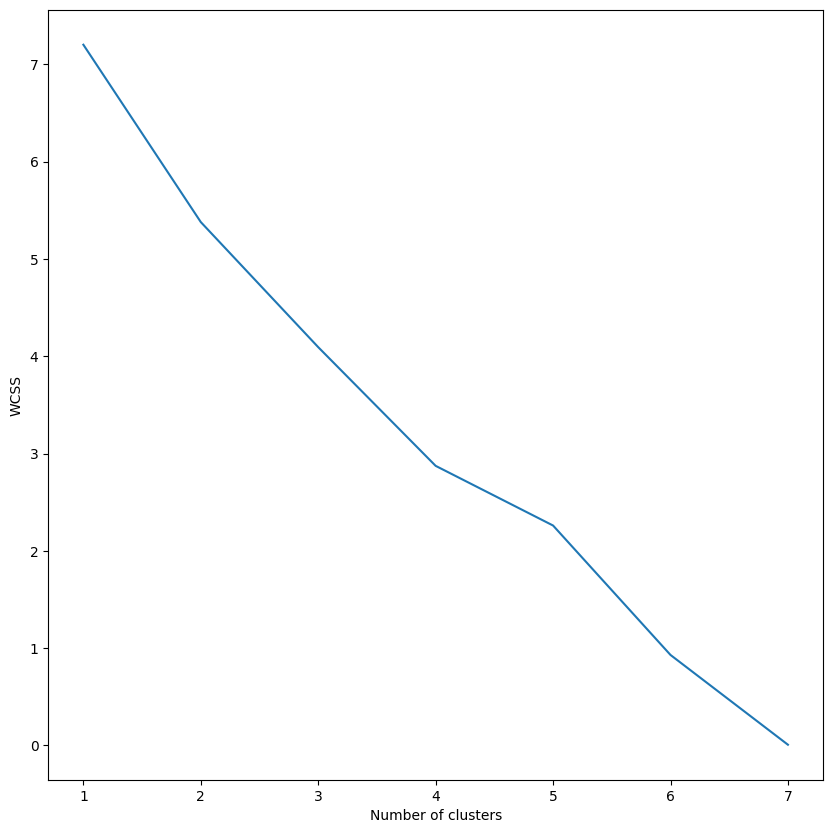

In [127]:
#kmeans_clustering = KMeans(n_clusters = 3, n_init = 3).fit_predict(X_tfidf)

#print(kmeans_clustering)

# def find_optimal_clusters(data, max_k):
#     iters = range(2, max_k+1, 2)
    
#     sse = []
#     for k in iters:
#         sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
#         print('Fit {} clusters'.format(k))
        
#     f, ax = plt.subplots(1, 1)
#     ax.plot(iters, sse, marker='o')
#     ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     ax.set_xticklabels(iters)
#     ax.set_ylabel('SSE')
#     ax.set_title('SSE by Cluster Center Plot')
    
# find_optimal_clusters(x, 5)

wcss = []
for i in range(1,8):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(df_topics)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,8), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [141]:
pca = PCA(9) #set to number of components
data = pca.fit_transform(df_topics) #apply principled component analysis

C:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



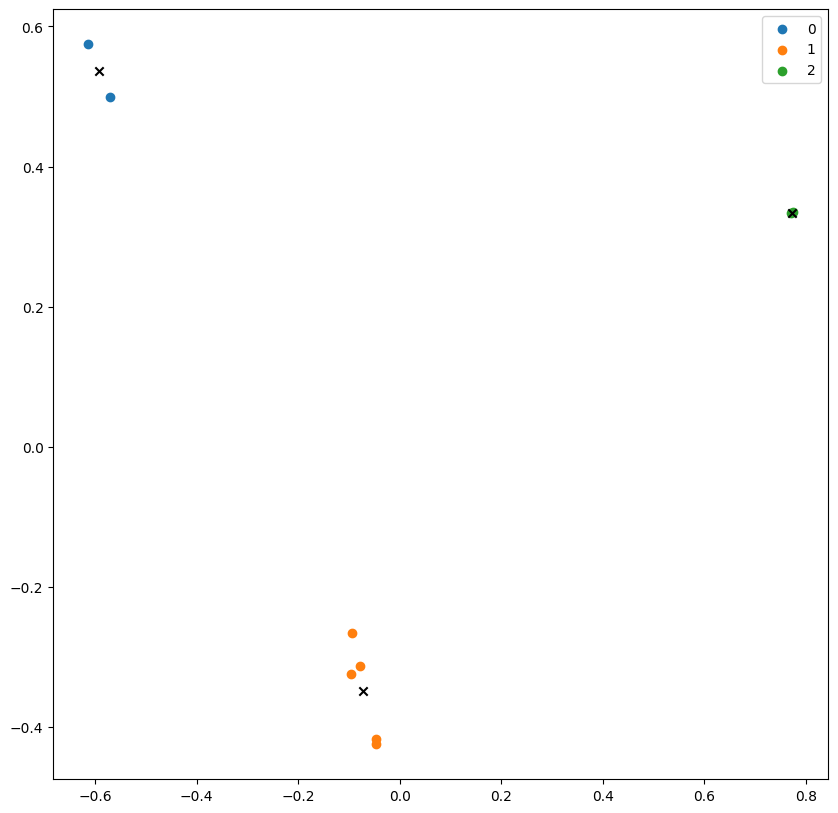

In [142]:

model = KMeans(n_clusters = 3, init = "k-means++")
label = model.fit_predict(data)
centers = np.array(model.cluster_centers_)

plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()